In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from keras.layers import Dropout

import tensorflow as tf
print(tf.__version__)
import time, sys
from IPython.display import clear_output

2.3.0


In [26]:
# read the raw data
def read_raw_data(filename='Infosys.csv'):
    raw_data = pd.read_csv(filename)
    raw_data = raw_data.dropna()
    raw_data = raw_data.drop(['Adj Close'], axis=1)
    return raw_data

# process the raw data
def process_raw(raw_data, n_lag, n_seq):
    
    for i in range(1,n_lag+1):
        var_name = 'Shifted Close Price ' + str(i)
        raw_data[var_name] = raw_data['Close'].shift(i)
        
    for i in range(1,n_seq+1):
        var_name = 'Shifted Close Price ' + str(-i)
        
    raw_data = raw_data.dropna()
    return raw_data

# processed_to_train_test
def train_test_reshape(raw_data, n_train_fraction=0.8):
    training_set = raw_data.values
    
    dates = training_set[:,0]
    sc_x = MinMaxScaler(feature_range = (0, 1))
    training_set_x_scaled = sc_x.fit_transform(training_set[:,1:11])
    sc_y = MinMaxScaler(feature_range = (0, 1))
    training_set_y_scaled = sc_y.fit_transform(training_set[:,10:11])
    
    n_train = int(len(training_set)*(n_train_fraction))
    train_sub_x = training_set_x_scaled[:n_train]
    train_sub_y = training_set_y_scaled[:n_train]
    training_dates = dates[:n_train]
    test_sub_x = training_set_x_scaled[n_train:]
    test_sub_y = training_set_y_scaled[n_train:]
    test_dates = dates[n_train:]

    x_train_cnn = train_sub_x.reshape(train_sub_x.shape[0],train_sub_x.shape[1],1)
    y_train_cnn = train_sub_y

    x_test_cnn = test_sub_x.reshape(test_sub_x.shape[0],test_sub_x.shape[1],1)
    y_test_cnn = test_sub_y
                  
    x_test_start_date = raw_data['Date'].values[n_train]
    x_test_end_date = raw_data['Date'].values[-1]

    return (x_train_cnn, y_train_cnn, x_test_cnn, y_test_cnn, 
            sc_y, test_dates)
                  
# build and fit cnn model
def build_and_train(x_train, y_train, n_layers=3, n_filters=[32,64,128]):
    input_shape = x_train_cnn.shape[1]
    output_shape = y_train_cnn.shape[1]

    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=n_filters[0], input_shape=(input_shape,1),
                         kernel_size=3, activation='relu'))
    for i in range(1,n_layers):
        cnn_model.add(Conv1D(filters=n_filters[i], kernel_size=1, activation='relu'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=32, activation='relu'))
    cnn_model.add(Dense(units=output_shape))

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=5,
                                                    mode='min')
                  
    cnn_model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                      optimizer=tf.optimizers.Adam(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()])
    cnn_model.fit(x_train_cnn, y_train_cnn, epochs=10, batch_size=1)
                  
    return cnn_model
                  
# save model
def save_model(model, model_name='cnn_model'):
    model.save(model_name)
    return None

# precit and plot
def predict_and_plot(mode, x_test, sc_y, dates):
    y_pred = cnn_model.predict(x_test)
    y_pred = sc_y.inverse_transform(y_pred)
    fig, (ax1) = plt.subplots(1,1, figsize=(20,5))
    ax1.plot(dates, y_pred)
    ax1.set_xticks(dates[::int(len(x_test)/10)])
    ax1.set_xticklabels(dates[::int(len(x_test)/10)], rotation=45)
    plt.show()
        

Epoch 1/10
4096/4096 [==============================] - 3s 830us/step - loss: 0.0146 - mean_absolute_error: 0.0146 - accuracy: 0.0000e+00
Epoch 2/10
4096/4096 [==============================] - 4s 869us/step - loss: 0.0108 - mean_absolute_error: 0.0108 - accuracy: 0.0000e+00
Epoch 3/10
4096/4096 [==============================] - 4s 908us/step - loss: 0.0094 - mean_absolute_error: 0.0094 - accuracy: 0.0000e+00
Epoch 4/10
4096/4096 [==============================] - 4s 856us/step - loss: 0.0080 - mean_absolute_error: 0.0080 - accuracy: 0.0000e+00
Epoch 5/10
4096/4096 [==============================] - 3s 841us/step - loss: 0.0076 - mean_absolute_error: 0.0076 - accuracy: 0.0000e+00
Epoch 6/10
4096/4096 [==============================] - 3s 840us/step - loss: 0.0070 - mean_absolute_error: 0.0070 - accuracy: 0.0000e+00
Epoch 7/10
4096/4096 [==============================] - 3s 836us/step - loss: 0.0067 - mean_absolute_error: 0.0067 - accuracy: 0.0000e+00
Epoch 8/10
4096/4096 [============

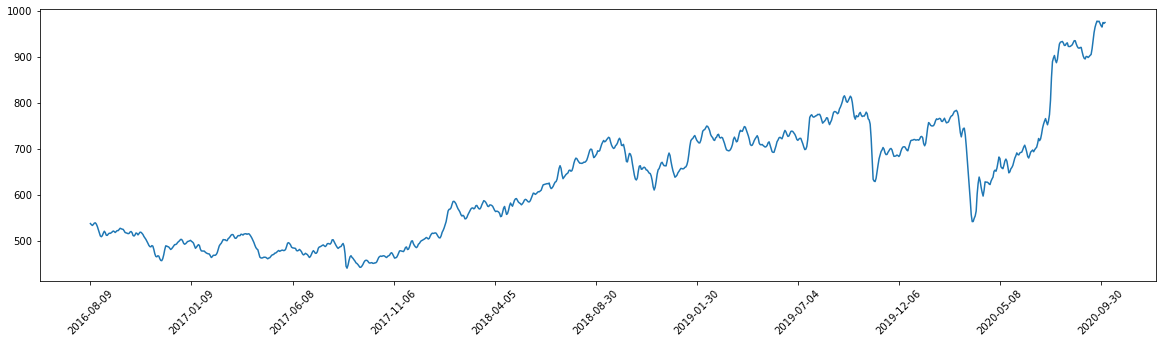

In [27]:
filename = 'Infosys.csv'
raw_data  = read_raw_data(filename)
raw_data = process_raw(raw_data, 5, 5)
x_train_cnn, y_train_cnn, x_test_cnn, y_test_cnn,sc_y, test_dates = train_test_reshape(raw_data)
cnn_model = build_and_train(x_train_cnn, y_train_cnn)
save_model(cnn_model)
predict_and_plot(cnn_model, x_test_cnn, sc_y, test_dates)

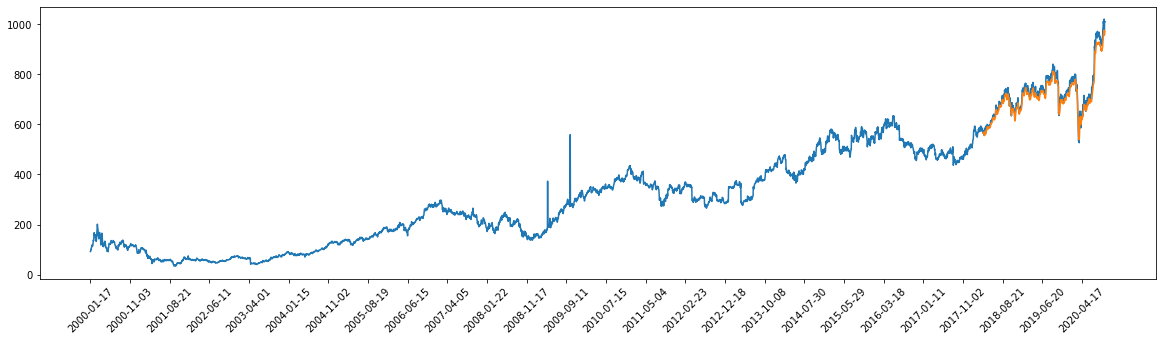

In [189]:
import numpy, matplotlib
fig, (ax1) = plt.subplots(1,1, figsize=(20,5))
df1 = pd.DataFrame(raw_data['Close'].values, index=raw_data['Date'], columns=['events'])
df2 = pd.DataFrame(y_pred, index=raw_data['Date'].values[4500:], columns=['events'])
ax1.plot(df1.index, df1.events)
ax1.plot(df2.index, df2.events)
ax1.set_xticks(raw_data['Date'][::200])
ax1.set_xticklabels(raw_data['Date'][::200], rotation=45)
plt.show()